# Access GLCFS model output from THREDDS Server with R

This notebook is help users get started using FVCOM output from the [GLERL THREDDS Server](https://www.glerl.noaa.gov/thredds/catalog/catalog.html). This example includes data from the Great Lakes Coastal Forecasting System ([GLCFS](https://www.glerl.noaa.gov/res/glcfs/)). Learn more about [GLCFS here](https://www.glerl.noaa.gov/res/Programs/ipemf/GLCFS_nextgen.html) and how to access both experimental and operational data on the [Data Access page here](https://www.glerl.noaa.gov/res/Programs/ipemf/glcfs_data_access.html).

For plotting in R, this script uses kml files that represent the FVCOM grid nodes and elements. Users can download the kml files from the [link here](https://www.glerl.noaa.gov/emf/kml/).

## Load required libraries

In [1]:
# install.packages(ncdf4)
# conda install -c conda-forge r-ncdf4
library(ncdf4)

# install.packages(sf)
# conda install -c conda-forge r-sf
library(sf)

# install.packages(codetools)
# conda install -c conda-forge r-codetools
library(codetools)

# install.packages(raster)
# conda install -c conda-forge r-raster
library(raster)

# install.packages(sf)
# conda install -c conda-forge r-fields
library(fields)

Linking to GEOS 3.9.1, GDAL 3.2.1, PROJ 7.2.1; sf_use_s2() is TRUE

Loading required package: sp

Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite


Try help(fields) to get started.



## Settings

In [2]:
lk <- 'erie'        # which lake?     superior | michigan-huron | hec | erie | ontario 
typ <- 'nowcast'    # type of output?  nowcast | forecast

ystrday <- format(as.Date(date(), format='%c')-1, format='%m%d%H')
mmddhh <- ystrday  # date (month day hour).... init time for forecasts;  *last* hour for nowcasts
#mmddhh <- '051500'  # or set manually to some specific day

## Build URL to read netCDF data

In [3]:
base_url <- 'https://www.glerl.noaa.gov/thredds/dodsC/glcfs/'
filename <- sprintf('%s_0001.nc', mmddhh)

url <- paste(base_url, lk, typ, filename, sep='/')

In [4]:
print(ystrday)

[1] "052200"


## Loading the FVCOM file

In [5]:
ncid <- nc_open(url)  # make sure to CLOSE netCDF stream later!  (otherwise errors will occur)
print(names(ncid$var))   # print all var names
print(ncatt_get(ncid, 'temp')) # print temperature metadata

 [1] "nprocs"             "partition"          "x"                 
 [4] "y"                  "lon"                "lat"               
 [7] "xc"                 "yc"                 "lonc"              
[10] "latc"               "siglay_center"      "siglev_center"     
[13] "h_center"           "h"                  "nv"                
[16] "iint"               "Itime"              "Itime2"            
[19] "Times"              "zeta"               "nbe"               
[22] "ntsn"               "nbsn"               "ntve"              
[25] "nbve"               "a1u"                "a2u"               
[28] "aw0"                "awx"                "awy"               
[31] "art2"               "art1"               "u"                 
[34] "v"                  "tauc"               "omega"             
[37] "ww"                 "ua"                 "va"                
[40] "temp"               "salinity"           "viscofm"           
[43] "viscofh"            "km"                 "

## Define a function to parse FVCOM dates & times

In [6]:
# hint:  add this function to your ~/.Rprofile
fvcom_dts <- function(ncid, origin='1970-01-01'){
        days <-  ncvar_get(ncid, "Itime") # days since unix epoch
        msec <- ncvar_get(ncid, "Itime2") # millisecs since day began
        # now convert to seconds and parse as POSIXct
        dts <- as.POSIXct(days*3600*24 + msec*1e-3, origin = origin, tz = "UTC")
        return(dts)
}

In [7]:
# now use the function
dts <- fvcom_dts(ncid)
print(dts)

 [1] "2023-05-21 13:00:00 UTC" "2023-05-21 14:00:00 UTC"
 [3] "2023-05-21 15:00:00 UTC" "2023-05-21 16:00:00 UTC"
 [5] "2023-05-21 17:00:00 UTC" "2023-05-21 18:00:00 UTC"
 [7] "2023-05-21 19:00:00 UTC" "2023-05-21 20:00:00 UTC"
 [9] "2023-05-21 21:00:00 UTC" "2023-05-21 22:00:00 UTC"
[11] "2023-05-21 23:00:00 UTC" "2023-05-22 00:00:00 UTC"


## Visualize FVCOM surface temperatures

Read in Thiessen Polygons corresponding to nodes and plot the surface temperature data. The voroni.kml file can be downloaded by [clicking here](https://www.glerl.noaa.gov/emf/kml/eri/voronoi.kml).

In [8]:
polys <- st_read('https://www.glerl.noaa.gov/emf/kml/eri/voronoi.kml')

Reading layer `voronoi' from data source 
  `https://www.glerl.noaa.gov/emf/kml/eri/voronoi.kml' using driver `KML'
Simple feature collection with 6106 features and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -83.47519 ymin: 41.38285 xmax: -78.854 ymax: 42.90551
Geodetic CRS:  WGS 84


png 
  3

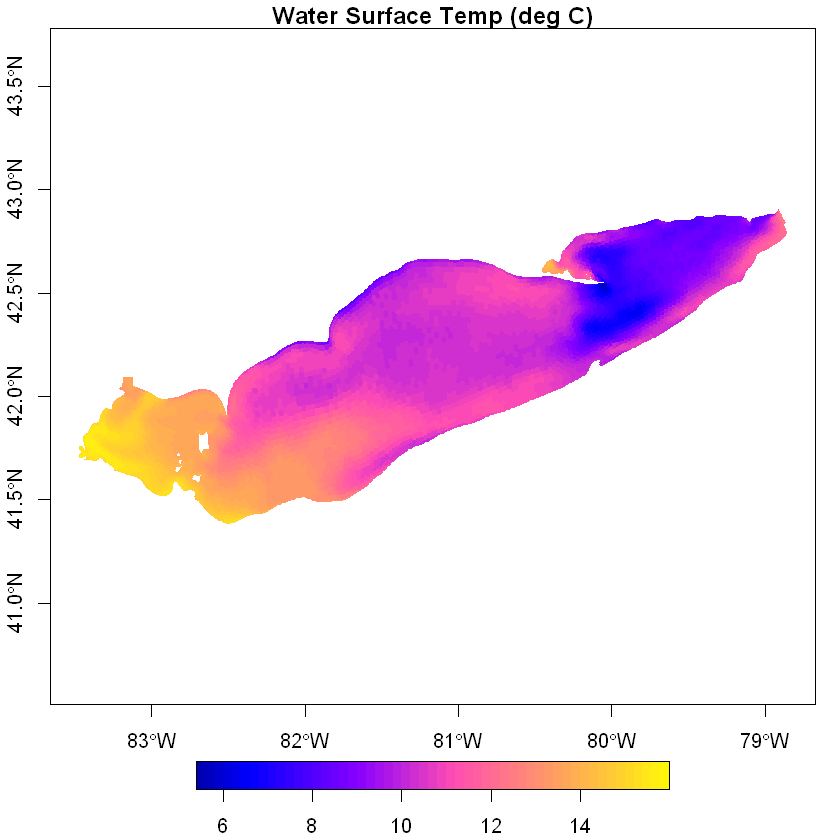

In [13]:
# read surface tmps and assign as attribute to SpatialPolygons
temp_sfc <- ncvar_get(ncid, 'temp')[,1,1]

polys$T <- temp_sfc

#draw plot
# png('sfc_T.png', width=1000, height=800)
plot(polys[,'T'], border=NA, axes=T, nbreaks=50, main='Water Surface Temp (deg C)')
dev.off()

## Read  & plot current normalized current field

To download the elems.kml file [click here](https://www.glerl.noaa.gov/emf/kml/eri/elems.kml).

In [14]:
x <- ncvar_get(ncid,'lonc')-360
y <- ncvar_get(ncid,'latc')
lay <- 1 # surface
t0 <- 1 # first time step

u <- ncvar_get(ncid, 'u')[,lay,t0]
v <- ncvar_get(ncid, 'v')[,lay,t0]

speed <- sqrt(u^2+v^2)*1e3 
elems <- st_read('https://www.glerl.noaa.gov/emf/kml/eri/elems.kml') # read in elements to get bounding box

png('currents.png', width=1200, height=800)
plot(extent(elems), col=NA, ax=T, xlab=NA, ylab=NA) # draw the canvas
arrows(x0=x, y0=y, x1=x+u/speed, y1=y+v/speed, length=.05, angle=25)
dev.off()

Reading layer `elements' from data source 
  `https://www.glerl.noaa.gov/emf/kml/eri/elems.kml' using driver `KML'
Simple feature collection with 11509 features and 2 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -83.47519 ymin: 41.38285 xmax: -78.854 ymax: 42.90551
Geodetic CRS:  WGS 84


png 
  2

## Extract a temperature profile near a given coordinate point

In [30]:
# define coords of interest
mylat <- 42 # degrees north
mylon <- -82 # longitude (negative degrees) West
mypts <- cbind(mylon, mylat)

In [31]:
# read in FVCOM coords and find nearest node
lat <- ncvar_get(ncid, 'lat')
lon <- ncvar_get(ncid, 'lon') - 360
pts <- cbind(lon, lat)
idx <- which.min(rdist.earth(mypts, pts))

print(cbind(lat[idx], lon[idx])) # print nearest coords for confirmation

         [,1]      [,2]
[1,] 41.99561 -82.01352


In [32]:
# read temperature profile at specific point
Tz <- ncvar_get(ncid, 'temp')[idx,,] # dimensions [ Z x time ]
h <- ncvar_get(ncid, 'h')[idx]
sig <- ncvar_get(ncid,'siglay')[idx,]
deps <- c(h) * as.vector(sig) # generate depths vector based on sigma levs

In [33]:
png('temp_vs_depth.png', width=1200, height=700, pointsize=20)
ti_str <- sprintf('water temp (deg C) at %4.1fN, %4.1fW', mylat, -mylon)
image.plot(x=dts, y=-deps, z=t(Tz), ylim=rev(range(-deps)), ylab='depth (meters)', xlab=NA, main=ti_str, xaxt='n')
axis.POSIXct(side=1, dts, format='%H:%MZ') 				 # label hour:minute on x-axis
axis.POSIXct(side=1, dts, format='%b-%d', line=1, lwd=0) # label month day below
dev.off()

png 
  2

In [34]:
nc_close(ncid)
# if netcdf stream isn't closed, errors will occur next time file is accessed